# Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are a class of machine learning models designed to generate new, realistic data. Given a set of real examples—such as images of faces—GANs can learn to produce new examples that are almost indistinguishable from the real ones.

This ability to generate data lies at the heart of what we now call **generative AI**—the technology behind tools that can create art, music, text, and even deepfake videos. GANs were a key breakthrough in this field, pushing generative models far beyond traditional methods in terms of realism.

However, the internal training mechanism of GANs is not intuitive at first. To build up to that, it's useful to start with a simpler concept: the **autoencoder**. Standard autoencoders are not generative in the usual sense—they learn to compress and reconstruct data but cannot generate new samples from scratch. However, with a small probabilistic twist, we arrive at **Variational Autoencoders (VAEs)**, which do become true generative models. Exploring this transition helps build intuition before we dive into the more complex adversarial training setup used in GANs.

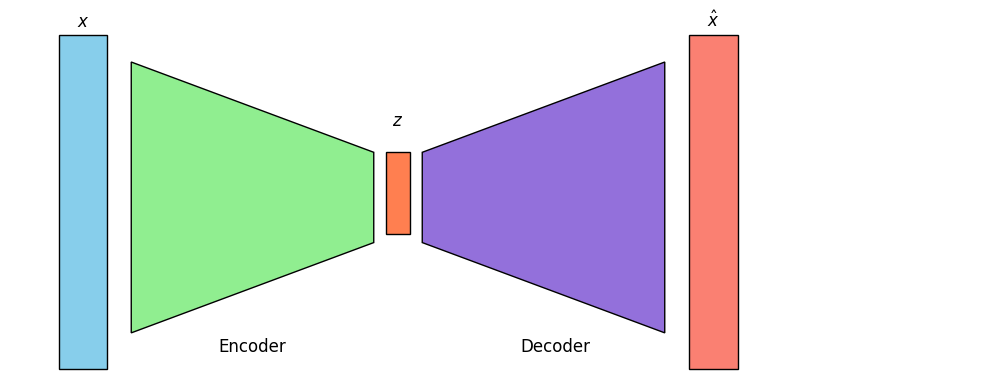

In [172]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle

def draw_triangle_autoencoder():
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('off')

    # Encoder triangle (left, green)
    encoder = Polygon([[1, 0.5], [3, 1.5], [3, 2.5], [1, 3.5]], closed=True, color='lightgreen', ec='black')
    ax.add_patch(encoder)

    # Decoder triangle (right, purple)
    decoder = Polygon([[5.4, 0.5], [3.4, 1.5], [3.4, 2.5], [5.4, 3.5]], closed=True, color='mediumpurple', ec='black')
    ax.add_patch(decoder)

    # Input/output rectangles (left and right)
    ax.add_patch(Rectangle((0.4, 0.1), 0.4, 3.7, color='skyblue', ec='black'))  # Input
    ax.add_patch(Rectangle((5.6, 0.1), 0.4, 3.7, color='salmon', ec='black'))   # Output

    # Bottleneck square (center)
    ax.add_patch(Rectangle((3.1, 1.6), 0.2, 0.9, color='coral', ec='black'))     # Latent

    # Text labels
    ax.text(0.6, 3.9, r"$x$", fontsize=12, ha='center')
    ax.text(5.8, 3.9, r"$\hat{x}$", fontsize=12, ha='center')
    ax.text(3.2, 2.8, r"$z$", fontsize=12, ha='center')
    ax.text(2.0, 0.3, "Encoder", ha='center', fontsize=12)
    ax.text(4.5, 0.3, "Decoder", ha='center', fontsize=12)

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 4)
    plt.tight_layout()
    plt.show()

draw_triangle_autoencoder()


**Autoencoders (AE)** are encoder/decoder type bottleneck architectures trained to reconstruct their input $x$ as $\hat{x}$. The encoder compresses the input into a low-dimensional latent vector $z$, and the decoder tries to reconstruct the original input from $z$.

While autoencoders are useful for tasks like denoising and dimensionality reduction, they are deterministic after training. The decoder expects structured latent codes produced by the encoder; feeding arbitrary noise instead will typically result in meaningless outputs. Therefore, standard autoencoders are not suitable for generative modeling.

**Variational autoencoders (VAE)** address this by introducing randomness in the latent space. The encoder outputs a mean and variance to model the latent code $z$ as a sample from a Gaussian distribution: $z \sim \mathcal{N}(\mu, \sigma^2)$. This makes the model stochastic, even during inference. In that case, there will be 2 ways this architecture can be used:


  * When used with input images, VAEs produce slightly varied versions of the input---this variation is not a performance limitation but it is intentional.
  * When used purely for generation, we discard the encoder and sample $z$ from a Gaussian distribution, feeding it directly into the decoder to generate meaningful data.

Despite being generative, VAEs tend to produce blurry or average-looking outputs, as they optimize a reconstruction likelihood rather than visual sharpness. This limitation motivates for other mechanisms which lead to the transition to **generative adversarial networks (GANs)**, which generate sharper and more realistic samples using an adversarial training strategy.

Before diving into GANs it is also important to have a grasp of the probabilistic interpretation of VAEs which will also help understanding GANs better. They are basically estimates of two probability densities; which is $q(z|X)$ (posterior for latent variables $z$) for the encoder and $p(X|z)$ (likelihood of obtaining $X$ for the given code $z$) for the decoder sides.


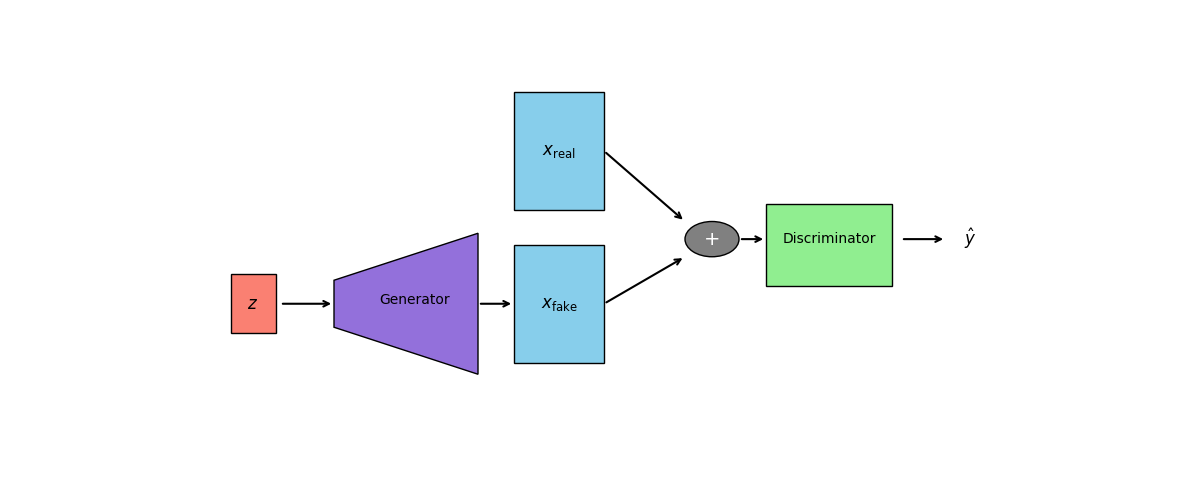

In [182]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle

def draw_gan_architecture():
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis('off')

    # Z (noise input)
    ax.add_patch(Rectangle((1.23, 2.25), 0.25, 0.5, color='salmon', ec='black'))
    ax.text(1.35, 2.5, r"$z$", ha='center', va='center', fontsize=12)

    # Generator block (shrunk)
    gen = Polygon([[1.8, 2.3], [2.6, 1.9 ], [2.6, 3.1], [1.8, 2.7]], closed=True, color='mediumpurple', ec='black')
    ax.add_patch(gen)
    ax.text(2.25, 2.5, "Generator", fontsize=10, ha='center')

    # Arrow from z to Generator
    ax.annotate("", xy=(1.8, 2.5), xytext=(1.5, 2.5), arrowprops=dict(arrowstyle='->', lw=1.5))

    # Fake output x_fake
    ax.add_patch(Rectangle((2.8, 2), 0.5, 1, color='skyblue', ec='black'))
    ax.text(3.05, 2.5, r"$x_{\mathrm{fake}}$", ha='center', va='center', fontsize=12)

    # Real input x_real (above fake, aligned)
    ax.add_patch(Rectangle((2.8, 3.3), 0.5, 1, color='skyblue', ec='black'))
    ax.text(3.05, 3.8, r"$x_{\mathrm{real}}$", ha='center', va='center', fontsize=12)

    # Arrow from Generator to x_fake
    ax.annotate("", xy=(2.8, 2.5), xytext=(2.6, 2.5), arrowprops=dict(arrowstyle='->', lw=1.5))

    # Concatenation node
    concat = Circle((3.9, 3.05), 0.15, color='gray', ec='black')
    ax.add_patch(concat)
    ax.text(3.9, 3.05, "+", ha='center', va='center', fontsize=14, color='white')

    # Arrows into concat node
    ax.annotate("", xy=(3.75, 2.9), xytext=(3.3, 2.5), arrowprops=dict(arrowstyle='->', lw=1.5))
    ax.annotate("", xy=(3.75, 3.2), xytext=(3.3, 3.8), arrowprops=dict(arrowstyle='->', lw=1.5))

    # Discriminator block (shrunk in width and height)
    ax.add_patch(Rectangle((4.2, 2.65), 0.7, 0.7, color='lightgreen', ec='black'))
    ax.text(4.55, 3.05, "Discriminator", ha='center', va='center', fontsize=10)

    # Arrow from concat to Discriminator
    ax.annotate("", xy=(4.2, 3.05), xytext=(4.05, 3.05), arrowprops=dict(arrowstyle='->', lw=1.5))

    # Output y_hat (no circle)
    ax.text(5.3, 3.05, r"$\hat{y}$", ha='left', va='center', fontsize=12)

    # Arrow to y_hat
    ax.annotate("", xy=(5.2, 3.05), xytext=(4.95, 3.05), arrowprops=dict(arrowstyle='->', lw=1.5))

    ax.set_xlim(0, 6.5)
    ax.set_ylim(1, 5)
    plt.tight_layout()
    plt.show()

draw_gan_architecture()

**GANs** consist of two competing neural networks: the **generator** and the **discriminator**. They are trained in a game-theoretic setting, hence the name *adversarial*.


  * The generator takes in random noise $z$ sampled from a known distribution, such as $\mathcal{N}(0, I)$ and tries to map it into realistic-looking data samples, such as images of human faces. This is generally an expanding network to generate meaningful signals from compressed noise and is drawn showing this expansion as in the case of VAE decoder side. This block is trying to model $p(X|y=1)$, i.e. what can be possible signals $X$ if we want them to be real ($y=1$).
  
  * The discriminator is a binary classifier that receives both real data samples $x_{\text{real}}$ and fake/generated samples $x_{\text{fake}}$, and tries to predict whether each input is authentic (real) or generated (fake). Thus, probabilistically it estimates $p(y|X)$ where $y=1$ if $X$ is real and $y=0$ otherwise.

You can think of the generator as an artist trying to forge artworks that are indistinguishable from the real ones, and the discriminator as an art critic or detective trained to spot fakes. The generator improves by learning how to deceive the discriminator, while the discriminator improves by learning how to catch the generator's flaws. The probabilistic interpretation given above is important to have a good grasp of their working mechanism although the GANs do not use explicit likelihood functions for optimization. This probabilistic view is even more apparent for **conditional GAN**s where there are more than 1 class they are trained to generate and those classes are selectable.

This adversarial process can be modeled as a minimax game:
$$
\min_G \max_D \; \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log(1 - D(G(z)))]
$$

Yes, this formula looks intimidating. It's like the mathematical version of saying:
“Let's have two neural networks play a cat-and-mouse game where one tries to generate fake images and the other tries to catch them.”

Here's what it actually means:


  * The discriminator $D$ is trained to assign high values to real images $x$ (maximize $\log D(x)$), and low values to fake images $G(z)$ (maximize $\log(1 - D(G(z)))$).
  * The generator $G$, on the other hand, tries to minimize that second term — in other words, it wants $D(G(z))$ to be close to 1, so the fake images are classified as real.

In plain English: the discriminator learns to tell real from fake, and the generator learns to make fakes that are indistinguishable from real ones. This tug-of-war ideally continues until neither can get better without the other also improving. It's a bit like two AI roommates trying to outsmart each other — one makes fake art, and the other critiques it — until both get really good at their jobs.

However, balancing this game is tricky. One network should not get better before the other, instead they should learn getting better concurrently, reinforcing each other even though they try to beat. Otherwise;

  * If the generator becomes too strong too early, it may fool the discriminator with low-quality outputs, effectively rewriting the rules of what counts as real.
  * If the discriminator dominates, it might quickly reject everything, providing no useful feedback to the generator.

So, choosing the right hyperparameters (e.g., learning rates, architectures, update frequencies) is essential to keep the training stable and meaningful. Unlike many other machine learning training scenarios this may end up with one network having high loss values even for the same training set if proper hyperparameters are not selected.

Once training is done, the discriminator is typically disconnected and destroyed if not used for further fine tuning. The remaining generator is now a good producer of the signal it was trained to generate.

## Face Generator Network

The above discussions are applied as an actual realization here as a face generation system. CelebA dataset is used for this project that has more than 200k images of celebrities. Here since the goal is creating a face generating network without huge quality concerns only a small subset is used (200 images only) but it can be increased as desired. The dataset can either be downloaded using the command below or manually from the link [here](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing) . The following code assumes there is a file named *img_align_celeba.zip* in the project location.

In [ ]:
!gdown --id 0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [4]:
import os
import zipfile
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt


# Unzip the archive
zip_path = "/content/img_align_celeba.zip"
extract_dir = "/content/celeba"
dummy_class_dir = os.path.join(extract_dir, "face")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Create a dummy class folder
os.makedirs(dummy_class_dir, exist_ok=True)

# Move images into the dummy class folder
img_src_dir = os.path.join(extract_dir, "img_align_celeba")
for filename in os.listdir(img_src_dir):
    file_path = os.path.join(img_src_dir, filename)
    if os.path.isfile(file_path):
        shutil.move(file_path, os.path.join(dummy_class_dir, filename))

# Cleanup: remove the now-empty original folder
os.rmdir(img_src_dir)

# Hyperparameters
latent_dim = 100
image_size = 64
batch_size = 128
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


dataset = ImageFolder(root=extract_dir, transform=transform)

# Slice a smaller dataset if needed
dataset_size = 200  # or None for full dataset
if dataset_size is not None:
    dataset = Subset(dataset, list(range(dataset_size)))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


The generator and discriminator architectures used here follow the standard design pattern of **DCGAN** (Deep Convolutional GAN), which has become a reliable baseline for image generation tasks.

**Generator**

The generator takes a low-dimensional latent vector $z$ and progressively upsamples it into a full-sized image using a stack of *ConvTranspose2d* layers (also known as transposed convolutions or "deconvolutions"). These layers are conceptually the inverse of regular convolution layers—they *increase* the spatial resolution instead of decreasing it. In this way, the generator starts from a small $1 \times 1$ noise map and expands it to a full $64 \times 64$ RGB image.

Each block consists of:
  * **ConvTranspose2d** to increase spatial size
  * **BatchNorm2d** for normalization
  * **ReLU** activation to encourage non-linearity

The final layer uses a *Tanh* activation, mapping the output to the range $[-1, 1]$, which matches the normalization used in preprocessing the real images.

**Discriminator**

The discriminator is a mirror-like convolutional network that takes an input image (real or fake) and outputs a single scalar probability indicating whether it believes the input is real. It uses a sequence of *Conv2d* layers to progressively reduce the spatial size, similar to a classification backbone.

Each block consists of:
  * **Conv2d** with stride 2 to downsample
  * **LeakyReLU** activation to avoid dying ReLU problem
  * **BatchNorm2d** to stabilize training (after the first layer)

The final layer is a $1 \times 1$ convolution followed by a *Sigmoid*, giving an output in $[0, 1]$ for binary classification.

Importantly, the discriminator is fully convolutional—it does not flatten or use a fully connected layer at the end. This helps preserve spatial structure and reduces the number of parameters, which is especially beneficial when working with limited data. This structure is typical for modern GANs and balances expressiveness with stability.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

### Training loop

This GAN setup is trained on a small subset of face images using a relatively lightweight model. It runs comfortably on a CPU and completes 150 epochs in under 30 minutes, making it ideal for demonstration purposes.

The training loop includes two main parts per batch:
1. **Training the discriminator** to distinguish real from fake images.
2. **Training the generator** to produce more realistic fake images that can fool the discriminator.

Even though the dataset is limited (200 images), the results are already promising:
- Starting from around epoch 20, the model begins generating face-like shapes instead of pure noise.
- By epoch 150, the generator produces recognizable (though slightly blurry) faces.


**Loss Calculation Strategy**

The **discriminator loss** is calculated in two separate steps:
- One for **real images** using labels of 1.
- One for **fake images** using labels of 0.
- These two losses are then summed to form the total discriminator loss:
$$
L_\text{D} = L_\text{real} + L_\text{fake}
$$

This separation is a design choice for clarity—it helps visually distinguish how the model reacts to real versus generated data. However, it's equally valid to concatenate the two inputs and compute the loss in one go. This is more or less, a matter of design choice.

#### Generator Loss

There is also the crucial aspect of calculating the **generator loss**.This is where the adversarial aspect kicks in. The generator wants to fool the discriminator. So, after generating fake images and passing them through the discriminator:
- We pretend these fakes are real by assigning them label 1.
- Then we compute the loss as:
$$
L_\text{G} = \text{BCE}(D(G(z)), 1)
$$

The type of loss functions used are same in both cases but the subset of data (only fakes for the generator) and the labelling are different.


**Tuning Observations**

Choosing the optimal **learning rates** for both the generator and the discriminator is crucial. As mentioned in the theoretical part, a mismatch can lead to:
* The generator dominating too quickly, producing low-quality images that the discriminator wrongly accepts.
* The discriminator dominating too early, rejecting everything and stalling generator improvement.

Some trial and error is required to find a balance where both networks improve each other in a stable loop.

**Why Are Images Blurry?**

The final outputs are fairly good, but slightly blurry. Possible reasons include:
- Limited training data (only 200 face images).
- Limited training time (150 epochs).
- GAN architecture: DCGAN-style generators tend to produce soft textures.
- No advanced tricks: No progressive growing, perceptual loss, or style-based improvements are used.

In short, this setup is simple but effective for informative purposes—and still capable of generating meaningful faces from pure noise. This is still remarkable because even in this basic form, faces are fairly complex objects and we can generate them from scratch.


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  1%|          | 1/150 [00:14<37:01, 14.91s/it]

Epoch [1/150]  Loss_D: 1.9115  Loss_G: 4.5812


  1%|▏         | 2/150 [00:27<33:25, 13.55s/it]

Epoch [2/150]  Loss_D: 0.9118  Loss_G: 4.6297


  2%|▏         | 3/150 [00:39<32:00, 13.07s/it]

Epoch [3/150]  Loss_D: 0.4287  Loss_G: 3.9333


  3%|▎         | 4/150 [00:52<31:28, 12.93s/it]

Epoch [4/150]  Loss_D: 0.3577  Loss_G: 3.9331


  3%|▎         | 5/150 [01:05<30:59, 12.82s/it]

Epoch [5/150]  Loss_D: 0.2924  Loss_G: 3.8771


  4%|▍         | 6/150 [01:18<30:54, 12.88s/it]

Epoch [6/150]  Loss_D: 0.3698  Loss_G: 3.7497


  5%|▍         | 7/150 [01:30<30:26, 12.77s/it]

Epoch [7/150]  Loss_D: 0.4051  Loss_G: 3.9019


  5%|▌         | 8/150 [01:43<30:02, 12.70s/it]

Epoch [8/150]  Loss_D: 0.4079  Loss_G: 3.9945


  6%|▌         | 9/150 [01:56<29:57, 12.75s/it]

Epoch [9/150]  Loss_D: 0.6846  Loss_G: 4.2792
Epoch [10/150]  Loss_D: 0.6749  Loss_G: 3.7784


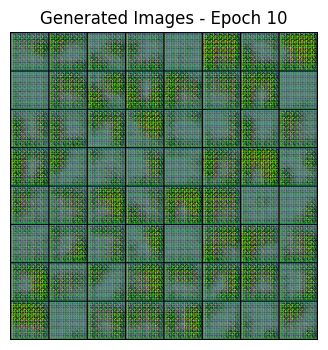

  7%|▋         | 11/150 [02:21<29:30, 12.74s/it]

Epoch [11/150]  Loss_D: 0.8940  Loss_G: 4.1773


  8%|▊         | 12/150 [02:34<29:16, 12.73s/it]

Epoch [12/150]  Loss_D: 0.5760  Loss_G: 3.7603


  9%|▊         | 13/150 [02:47<29:08, 12.76s/it]

Epoch [13/150]  Loss_D: 0.8218  Loss_G: 4.3111


  9%|▉         | 14/150 [02:59<28:49, 12.72s/it]

Epoch [14/150]  Loss_D: 0.8156  Loss_G: 3.7603


 10%|█         | 15/150 [03:12<28:37, 12.73s/it]

Epoch [15/150]  Loss_D: 0.6618  Loss_G: 3.6824


 11%|█         | 16/150 [03:25<28:25, 12.73s/it]

Epoch [16/150]  Loss_D: 1.0120  Loss_G: 4.8979


 11%|█▏        | 17/150 [03:37<28:03, 12.66s/it]

Epoch [17/150]  Loss_D: 1.3333  Loss_G: 4.7373


 12%|█▏        | 18/150 [03:50<27:39, 12.57s/it]

Epoch [18/150]  Loss_D: 1.5695  Loss_G: 3.9529


 13%|█▎        | 19/150 [04:02<27:17, 12.50s/it]

Epoch [19/150]  Loss_D: 1.3851  Loss_G: 4.3085
Epoch [20/150]  Loss_D: 0.9892  Loss_G: 3.1638


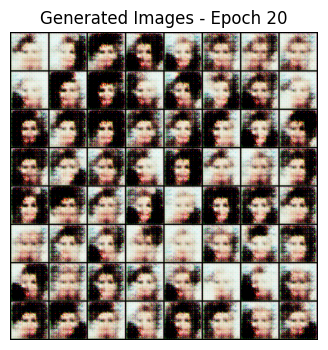

 14%|█▍        | 21/150 [04:27<26:59, 12.55s/it]

Epoch [21/150]  Loss_D: 2.2446  Loss_G: 2.0849


 15%|█▍        | 22/150 [04:40<26:36, 12.47s/it]

Epoch [22/150]  Loss_D: 2.3237  Loss_G: 2.2594


 15%|█▌        | 23/150 [04:52<26:26, 12.49s/it]

Epoch [23/150]  Loss_D: 1.7974  Loss_G: 2.2377


 16%|█▌        | 24/150 [05:05<26:21, 12.55s/it]

Epoch [24/150]  Loss_D: 1.9151  Loss_G: 2.1356


 17%|█▋        | 25/150 [05:18<26:17, 12.62s/it]

Epoch [25/150]  Loss_D: 2.1982  Loss_G: 2.1472


 17%|█▋        | 26/150 [05:30<25:55, 12.55s/it]

Epoch [26/150]  Loss_D: 2.0155  Loss_G: 2.3025


 18%|█▊        | 27/150 [05:42<25:35, 12.48s/it]

Epoch [27/150]  Loss_D: 2.0091  Loss_G: 1.6153


 19%|█▊        | 28/150 [05:55<25:21, 12.47s/it]

Epoch [28/150]  Loss_D: 2.4720  Loss_G: 1.7927


 19%|█▉        | 29/150 [06:07<25:06, 12.45s/it]

Epoch [29/150]  Loss_D: 2.2117  Loss_G: 1.6884
Epoch [30/150]  Loss_D: 2.0096  Loss_G: 1.4613


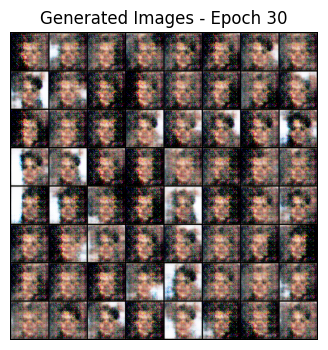

 21%|██        | 31/150 [06:33<24:57, 12.59s/it]

Epoch [31/150]  Loss_D: 2.2465  Loss_G: 1.6620


 21%|██▏       | 32/150 [06:45<24:30, 12.46s/it]

Epoch [32/150]  Loss_D: 2.6617  Loss_G: 1.5848


 22%|██▏       | 33/150 [06:57<24:05, 12.35s/it]

Epoch [33/150]  Loss_D: 1.7343  Loss_G: 1.7601


 23%|██▎       | 34/150 [07:09<23:43, 12.27s/it]

Epoch [34/150]  Loss_D: 2.4473  Loss_G: 1.6963


 23%|██▎       | 35/150 [07:22<23:43, 12.38s/it]

Epoch [35/150]  Loss_D: 1.8659  Loss_G: 1.7988


 24%|██▍       | 36/150 [07:34<23:19, 12.28s/it]

Epoch [36/150]  Loss_D: 1.8594  Loss_G: 1.1408


 25%|██▍       | 37/150 [07:46<23:03, 12.25s/it]

Epoch [37/150]  Loss_D: 1.7796  Loss_G: 0.9608


 25%|██▌       | 38/150 [07:58<22:57, 12.30s/it]

Epoch [38/150]  Loss_D: 1.5293  Loss_G: 1.1534


 26%|██▌       | 39/150 [08:11<22:43, 12.28s/it]

Epoch [39/150]  Loss_D: 1.6628  Loss_G: 1.2537
Epoch [40/150]  Loss_D: 1.7627  Loss_G: 1.4650


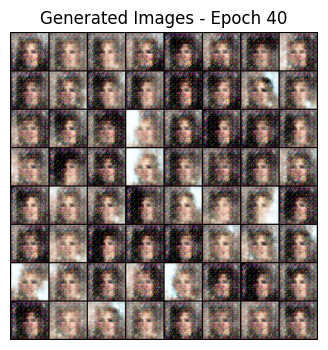

 27%|██▋       | 41/150 [08:36<22:38, 12.46s/it]

Epoch [41/150]  Loss_D: 1.7882  Loss_G: 1.2007


 28%|██▊       | 42/150 [08:48<22:20, 12.41s/it]

Epoch [42/150]  Loss_D: 1.6579  Loss_G: 1.0559


 29%|██▊       | 43/150 [09:02<22:38, 12.69s/it]

Epoch [43/150]  Loss_D: 1.8045  Loss_G: 0.8590


 29%|██▉       | 44/150 [09:14<22:16, 12.61s/it]

Epoch [44/150]  Loss_D: 1.6300  Loss_G: 1.1069


 30%|███       | 45/150 [09:27<22:01, 12.59s/it]

Epoch [45/150]  Loss_D: 1.5465  Loss_G: 1.1419


 31%|███       | 46/150 [09:39<21:53, 12.63s/it]

Epoch [46/150]  Loss_D: 1.5625  Loss_G: 0.9768


 31%|███▏      | 47/150 [09:52<21:42, 12.65s/it]

Epoch [47/150]  Loss_D: 1.5368  Loss_G: 1.0521


 32%|███▏      | 48/150 [10:04<21:22, 12.57s/it]

Epoch [48/150]  Loss_D: 1.6634  Loss_G: 1.0567


 33%|███▎      | 49/150 [10:17<21:07, 12.55s/it]

Epoch [49/150]  Loss_D: 1.8736  Loss_G: 1.3116
Epoch [50/150]  Loss_D: 1.5828  Loss_G: 1.7903


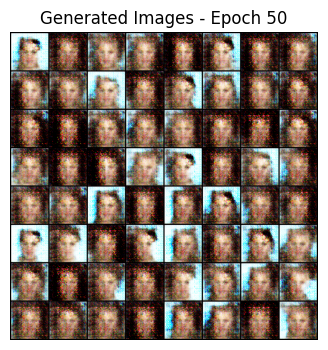

 34%|███▍      | 51/150 [10:43<20:55, 12.68s/it]

Epoch [51/150]  Loss_D: 1.6563  Loss_G: 0.8105


 35%|███▍      | 52/150 [10:55<20:44, 12.70s/it]

Epoch [52/150]  Loss_D: 1.5746  Loss_G: 1.0397


 35%|███▌      | 53/150 [11:08<20:27, 12.65s/it]

Epoch [53/150]  Loss_D: 1.3723  Loss_G: 1.0596


 36%|███▌      | 54/150 [11:21<20:15, 12.66s/it]

Epoch [54/150]  Loss_D: 1.5900  Loss_G: 1.0486


 37%|███▋      | 55/150 [11:33<20:02, 12.66s/it]

Epoch [55/150]  Loss_D: 1.5663  Loss_G: 1.4729


 37%|███▋      | 56/150 [11:46<19:54, 12.71s/it]

Epoch [56/150]  Loss_D: 1.6005  Loss_G: 1.0670


 38%|███▊      | 57/150 [11:59<19:42, 12.71s/it]

Epoch [57/150]  Loss_D: 1.7354  Loss_G: 1.2867


 39%|███▊      | 58/150 [12:11<19:28, 12.71s/it]

Epoch [58/150]  Loss_D: 1.5360  Loss_G: 1.1357


 39%|███▉      | 59/150 [12:24<19:21, 12.76s/it]

Epoch [59/150]  Loss_D: 1.6911  Loss_G: 0.9801
Epoch [60/150]  Loss_D: 1.4226  Loss_G: 1.1166


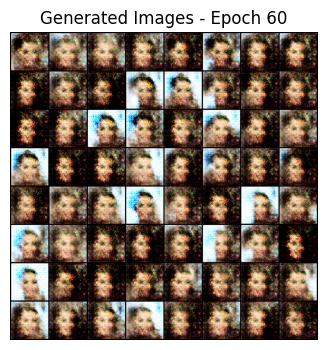

 41%|████      | 61/150 [12:51<19:09, 12.92s/it]

Epoch [61/150]  Loss_D: 1.4712  Loss_G: 1.0503


 41%|████▏     | 62/150 [13:03<18:52, 12.87s/it]

Epoch [62/150]  Loss_D: 1.6477  Loss_G: 1.2113


 42%|████▏     | 63/150 [13:16<18:39, 12.87s/it]

Epoch [63/150]  Loss_D: 1.5831  Loss_G: 1.1957


 43%|████▎     | 64/150 [13:29<18:28, 12.89s/it]

Epoch [64/150]  Loss_D: 1.4253  Loss_G: 1.1205


 43%|████▎     | 65/150 [13:42<18:16, 12.90s/it]

Epoch [65/150]  Loss_D: 1.4249  Loss_G: 1.1786


 44%|████▍     | 66/150 [13:55<18:00, 12.87s/it]

Epoch [66/150]  Loss_D: 1.5789  Loss_G: 1.0375


 45%|████▍     | 67/150 [14:08<17:48, 12.87s/it]

Epoch [67/150]  Loss_D: 1.6497  Loss_G: 0.9623


 45%|████▌     | 68/150 [14:21<17:36, 12.89s/it]

Epoch [68/150]  Loss_D: 1.6806  Loss_G: 0.9948


 46%|████▌     | 69/150 [14:34<17:24, 12.90s/it]

Epoch [69/150]  Loss_D: 1.5656  Loss_G: 1.0753
Epoch [70/150]  Loss_D: 1.4306  Loss_G: 1.0092


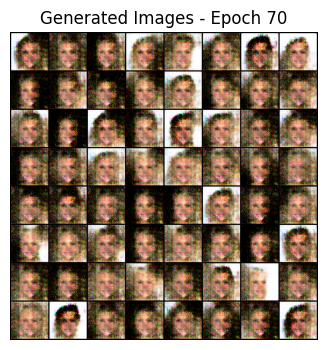

 47%|████▋     | 71/150 [15:00<16:59, 12.91s/it]

Epoch [71/150]  Loss_D: 1.4949  Loss_G: 0.9973


 48%|████▊     | 72/150 [15:12<16:42, 12.85s/it]

Epoch [72/150]  Loss_D: 1.5854  Loss_G: 1.1517


 49%|████▊     | 73/150 [15:25<16:22, 12.76s/it]

Epoch [73/150]  Loss_D: 1.5186  Loss_G: 1.1732


 49%|████▉     | 74/150 [15:38<16:06, 12.72s/it]

Epoch [74/150]  Loss_D: 1.7917  Loss_G: 1.0974


 50%|█████     | 75/150 [15:50<15:48, 12.64s/it]

Epoch [75/150]  Loss_D: 1.7350  Loss_G: 0.9725


 51%|█████     | 76/150 [16:03<15:37, 12.67s/it]

Epoch [76/150]  Loss_D: 1.3305  Loss_G: 1.1210


 51%|█████▏    | 77/150 [16:16<15:26, 12.70s/it]

Epoch [77/150]  Loss_D: 1.1591  Loss_G: 1.1103


 52%|█████▏    | 78/150 [16:28<15:13, 12.68s/it]

Epoch [78/150]  Loss_D: 1.3814  Loss_G: 0.9826


 53%|█████▎    | 79/150 [16:41<14:54, 12.59s/it]

Epoch [79/150]  Loss_D: 1.5725  Loss_G: 1.5312
Epoch [80/150]  Loss_D: 1.5986  Loss_G: 1.0228


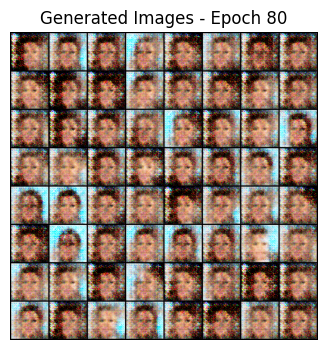

 54%|█████▍    | 81/150 [17:06<14:39, 12.74s/it]

Epoch [81/150]  Loss_D: 1.8173  Loss_G: 1.1693


 55%|█████▍    | 82/150 [17:19<14:27, 12.76s/it]

Epoch [82/150]  Loss_D: 1.5393  Loss_G: 1.2456


 55%|█████▌    | 83/150 [17:32<14:16, 12.78s/it]

Epoch [83/150]  Loss_D: 1.4423  Loss_G: 0.9538


 56%|█████▌    | 84/150 [17:45<14:06, 12.82s/it]

Epoch [84/150]  Loss_D: 1.5203  Loss_G: 0.8594


 57%|█████▋    | 85/150 [17:58<13:51, 12.79s/it]

Epoch [85/150]  Loss_D: 1.5764  Loss_G: 0.8413


 57%|█████▋    | 86/150 [18:10<13:36, 12.76s/it]

Epoch [86/150]  Loss_D: 1.4379  Loss_G: 0.8703


 58%|█████▊    | 87/150 [18:23<13:22, 12.74s/it]

Epoch [87/150]  Loss_D: 1.4517  Loss_G: 0.8516


 59%|█████▊    | 88/150 [18:36<13:16, 12.85s/it]

Epoch [88/150]  Loss_D: 1.4498  Loss_G: 0.8950


 59%|█████▉    | 89/150 [18:49<12:59, 12.78s/it]

Epoch [89/150]  Loss_D: 1.4740  Loss_G: 0.8249
Epoch [90/150]  Loss_D: 1.4674  Loss_G: 0.9329


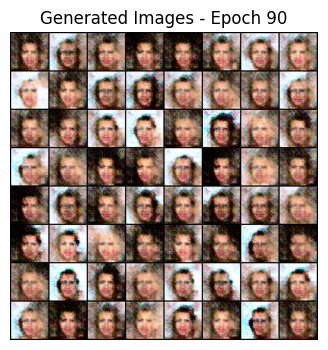

 61%|██████    | 91/150 [19:15<12:39, 12.87s/it]

Epoch [91/150]  Loss_D: 1.4398  Loss_G: 0.9185


 61%|██████▏   | 92/150 [19:28<12:31, 12.96s/it]

Epoch [92/150]  Loss_D: 1.4423  Loss_G: 0.9259


 62%|██████▏   | 93/150 [19:41<12:17, 12.93s/it]

Epoch [93/150]  Loss_D: 1.5512  Loss_G: 1.0723


 63%|██████▎   | 94/150 [19:54<12:04, 12.94s/it]

Epoch [94/150]  Loss_D: 1.4624  Loss_G: 1.0746


 63%|██████▎   | 95/150 [20:06<11:49, 12.89s/it]

Epoch [95/150]  Loss_D: 1.6632  Loss_G: 0.9353


 64%|██████▍   | 96/150 [20:19<11:33, 12.85s/it]

Epoch [96/150]  Loss_D: 1.6910  Loss_G: 1.1302


 65%|██████▍   | 97/150 [20:32<11:23, 12.89s/it]

Epoch [97/150]  Loss_D: 1.2370  Loss_G: 1.2516


 65%|██████▌   | 98/150 [20:45<11:09, 12.88s/it]

Epoch [98/150]  Loss_D: 1.5221  Loss_G: 0.9379


 66%|██████▌   | 99/150 [20:58<10:53, 12.81s/it]

Epoch [99/150]  Loss_D: 1.6469  Loss_G: 1.0387
Epoch [100/150]  Loss_D: 1.4870  Loss_G: 0.9466


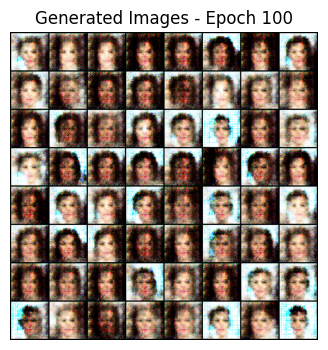

 67%|██████▋   | 101/150 [21:23<10:24, 12.74s/it]

Epoch [101/150]  Loss_D: 1.5389  Loss_G: 0.9408


 68%|██████▊   | 102/150 [21:36<10:12, 12.75s/it]

Epoch [102/150]  Loss_D: 1.4781  Loss_G: 0.9326


 69%|██████▊   | 103/150 [21:49<09:58, 12.72s/it]

Epoch [103/150]  Loss_D: 1.4997  Loss_G: 0.8901


 69%|██████▉   | 104/150 [22:01<09:42, 12.66s/it]

Epoch [104/150]  Loss_D: 1.5628  Loss_G: 0.8806


 70%|███████   | 105/150 [22:14<09:28, 12.62s/it]

Epoch [105/150]  Loss_D: 1.4180  Loss_G: 0.9379


 71%|███████   | 106/150 [22:26<09:12, 12.56s/it]

Epoch [106/150]  Loss_D: 1.3739  Loss_G: 0.9071


 71%|███████▏  | 107/150 [22:39<08:59, 12.55s/it]

Epoch [107/150]  Loss_D: 1.3472  Loss_G: 0.8822


 72%|███████▏  | 108/150 [22:51<08:44, 12.50s/it]

Epoch [108/150]  Loss_D: 1.4030  Loss_G: 0.8792


 73%|███████▎  | 109/150 [23:03<08:31, 12.47s/it]

Epoch [109/150]  Loss_D: 1.3827  Loss_G: 0.9081
Epoch [110/150]  Loss_D: 1.3220  Loss_G: 0.9595


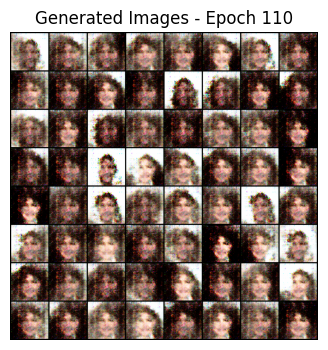

 74%|███████▍  | 111/150 [23:29<08:08, 12.54s/it]

Epoch [111/150]  Loss_D: 1.3429  Loss_G: 0.8343


 75%|███████▍  | 112/150 [23:41<07:55, 12.52s/it]

Epoch [112/150]  Loss_D: 1.3952  Loss_G: 0.9612


 75%|███████▌  | 113/150 [23:54<07:42, 12.50s/it]

Epoch [113/150]  Loss_D: 1.4445  Loss_G: 0.9621


 76%|███████▌  | 114/150 [24:06<07:29, 12.50s/it]

Epoch [114/150]  Loss_D: 1.4457  Loss_G: 0.8830


 77%|███████▋  | 115/150 [24:19<07:17, 12.49s/it]

Epoch [115/150]  Loss_D: 1.4282  Loss_G: 0.7929


 77%|███████▋  | 116/150 [24:31<07:04, 12.48s/it]

Epoch [116/150]  Loss_D: 1.5004  Loss_G: 0.9223


 78%|███████▊  | 117/150 [24:44<06:52, 12.50s/it]

Epoch [117/150]  Loss_D: 1.3008  Loss_G: 1.0439


 79%|███████▊  | 118/150 [24:56<06:39, 12.49s/it]

Epoch [118/150]  Loss_D: 1.2623  Loss_G: 0.9347


 79%|███████▉  | 119/150 [25:09<06:27, 12.51s/it]

Epoch [119/150]  Loss_D: 1.3375  Loss_G: 0.9111
Epoch [120/150]  Loss_D: 1.3911  Loss_G: 0.9050


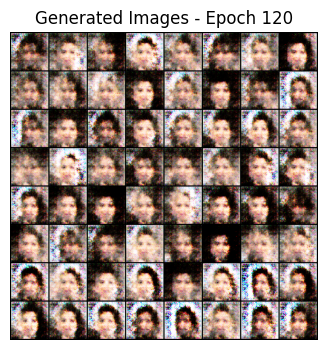

 81%|████████  | 121/150 [25:34<06:05, 12.60s/it]

Epoch [121/150]  Loss_D: 1.5313  Loss_G: 1.1620


 81%|████████▏ | 122/150 [25:47<05:52, 12.59s/it]

Epoch [122/150]  Loss_D: 1.4133  Loss_G: 1.1429


 82%|████████▏ | 123/150 [25:59<05:40, 12.61s/it]

Epoch [123/150]  Loss_D: 1.3539  Loss_G: 1.0091


 83%|████████▎ | 124/150 [26:12<05:30, 12.70s/it]

Epoch [124/150]  Loss_D: 1.3918  Loss_G: 0.9421


 83%|████████▎ | 125/150 [26:25<05:16, 12.68s/it]

Epoch [125/150]  Loss_D: 1.5373  Loss_G: 1.0065


 84%|████████▍ | 126/150 [26:37<05:04, 12.68s/it]

Epoch [126/150]  Loss_D: 1.4805  Loss_G: 1.0418


 85%|████████▍ | 127/150 [26:50<04:51, 12.68s/it]

Epoch [127/150]  Loss_D: 1.4857  Loss_G: 0.9281


 85%|████████▌ | 128/150 [27:03<04:38, 12.68s/it]

Epoch [128/150]  Loss_D: 1.3888  Loss_G: 0.9489


 86%|████████▌ | 129/150 [27:15<04:25, 12.62s/it]

Epoch [129/150]  Loss_D: 1.3066  Loss_G: 1.0002
Epoch [130/150]  Loss_D: 1.2505  Loss_G: 1.0252


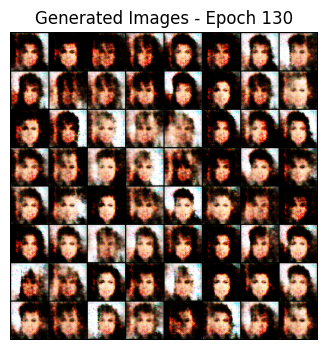

 87%|████████▋ | 131/150 [27:41<04:02, 12.78s/it]

Epoch [131/150]  Loss_D: 1.4099  Loss_G: 1.0676


 88%|████████▊ | 132/150 [27:54<03:49, 12.77s/it]

Epoch [132/150]  Loss_D: 1.3946  Loss_G: 1.0110


 89%|████████▊ | 133/150 [28:07<03:38, 12.84s/it]

Epoch [133/150]  Loss_D: 1.2154  Loss_G: 0.9958


 89%|████████▉ | 134/150 [28:20<03:25, 12.86s/it]

Epoch [134/150]  Loss_D: 1.3057  Loss_G: 0.9539


 90%|█████████ | 135/150 [28:33<03:13, 12.91s/it]

Epoch [135/150]  Loss_D: 1.5949  Loss_G: 0.9595


 91%|█████████ | 136/150 [28:46<03:00, 12.91s/it]

Epoch [136/150]  Loss_D: 1.4508  Loss_G: 1.0537


 91%|█████████▏| 137/150 [28:59<02:46, 12.84s/it]

Epoch [137/150]  Loss_D: 1.3715  Loss_G: 0.9623


 92%|█████████▏| 138/150 [29:11<02:34, 12.88s/it]

Epoch [138/150]  Loss_D: 1.3333  Loss_G: 0.9723


 93%|█████████▎| 139/150 [29:24<02:20, 12.82s/it]

Epoch [139/150]  Loss_D: 1.4098  Loss_G: 0.8968
Epoch [140/150]  Loss_D: 1.3579  Loss_G: 1.0683


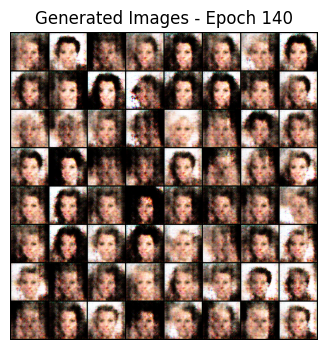

 94%|█████████▍| 141/150 [29:50<01:55, 12.88s/it]

Epoch [141/150]  Loss_D: 1.3765  Loss_G: 0.9833


 95%|█████████▍| 142/150 [30:03<01:42, 12.79s/it]

Epoch [142/150]  Loss_D: 1.3359  Loss_G: 1.0454


 95%|█████████▌| 143/150 [30:16<01:29, 12.81s/it]

Epoch [143/150]  Loss_D: 1.4148  Loss_G: 0.9803


 96%|█████████▌| 144/150 [30:28<01:16, 12.71s/it]

Epoch [144/150]  Loss_D: 1.5405  Loss_G: 0.9779


 97%|█████████▋| 145/150 [30:41<01:03, 12.74s/it]

Epoch [145/150]  Loss_D: 1.3605  Loss_G: 1.0086


 97%|█████████▋| 146/150 [30:54<00:51, 12.79s/it]

Epoch [146/150]  Loss_D: 1.3317  Loss_G: 1.0060


 98%|█████████▊| 147/150 [31:07<00:38, 12.80s/it]

Epoch [147/150]  Loss_D: 1.3852  Loss_G: 0.9483


 99%|█████████▊| 148/150 [31:19<00:25, 12.70s/it]

Epoch [148/150]  Loss_D: 1.3702  Loss_G: 0.8878


 99%|█████████▉| 149/150 [31:32<00:12, 12.66s/it]

Epoch [149/150]  Loss_D: 1.3692  Loss_G: 0.9608
Epoch [150/150]  Loss_D: 1.3469  Loss_G: 1.1328


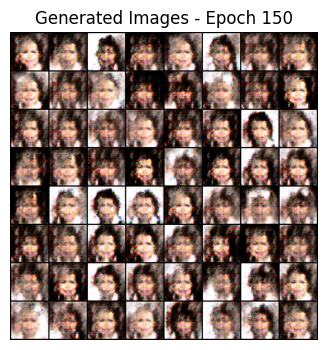

100%|██████████| 150/150 [31:45<00:00, 12.70s/it]


In [183]:
from tqdm import tqdm
import torchvision.utils as vutils

import random
import os
import numpy as np
import torch

def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed(0)


def generate_and_show_images(generator, epoch, n_images=64):
    generator.eval()
    z = torch.randn(n_images, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(z).cpu()

    grid = vutils.make_grid(fake_images, nrow=8, normalize=True)
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Init models
gen_model = Generator().to(device)
disc_model = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(disc_model.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(gen_model.parameters(), lr=1e-2, betas=(0.5, 0.999))

# Training
epochs=150
for epoch in tqdm(range(1, epochs+1)):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        b_size = imgs.size(0)

        # Image classification labels where 1 for real ones and 0 for imposters
        real_labels = torch.full((b_size,), 1., device=device)
        fake_labels = torch.full((b_size,), 0., device=device)

        # Train Discriminator
        disc_model.zero_grad()
        output_real = disc_model(imgs)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_imgs = gen_model(noise)
        output_fake = disc_model(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake # these two can be concatanated instead of calculating separate losses but I keep it like that to visually distinguish loss calculation between real and fakes
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        gen_model.zero_grad()
        output_fake = disc_model(fake_imgs)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch}/{epochs}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}")

    if epoch % 10 == 0:
        generate_and_show_images(gen_model, epoch)


In [186]:
# Saving generator is sufficient for most inference purposes, if no fine tuning will be done later.
torch.save(gen_model.state_dict(), "generator.pth")

# To recover the model weights for generator
gen_model = Generator()
gen_model.load_state_dict(torch.load("generator.pth"))

### Controllable Generation

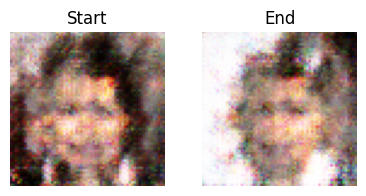

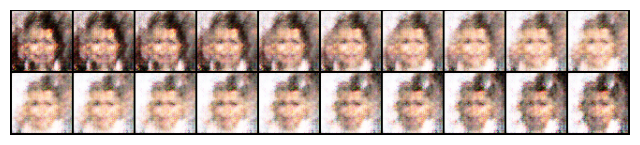

In [21]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import random
import numpy as np
import torch

def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed(0)

# Set generator to evaluation mode
gen_model.eval()

# Generate two independent latent vectors
z_start = torch.randn(1, 100, 1, 1, device=device)
z_end = torch.randn(1, 100, 1, 1, device=device)

# Number of interpolation steps
num_steps = 20

# Calculate the direction vector from start to end
delta = z_end - z_start

# Interpolation steps
z_list = []
for alpha in torch.linspace(0, 1, steps=num_steps):
    z_interp = z_start + alpha * delta
    z_list.append(z_interp)

# Concatenate all interpolated latent vectors
z = torch.cat(z_list, dim=0)

# Generate images
with torch.no_grad():
    fake_images = gen_model(z).cpu()

with torch.no_grad():
    img_start = np.transpose(gen_model(z_start).cpu()[0], (1, 2, 0))
    img_end = np.transpose(gen_model(z_end).cpu()[0], (1, 2, 0))

# Normalize to [0, 1]
img_start = (img_start + 1) / 2
img_end = (img_end + 1) / 2

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(4, 2))  # width x height
axs[0].imshow(img_start)
axs[0].axis("off")
axs[0].set_title("Start")

axs[1].imshow(img_end)
axs[1].axis("off")
axs[1].set_title("End")

plt.tight_layout()
plt.show()

# Visualize
grid = vutils.make_grid(fake_images, nrow=10, normalize=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

The figure above shows interpolation in the generator's latent space. The two large images at the top represent the starting and ending points---each corresponding to a latent vector that generates a particular face. The grid below displays intermediate faces generated by linearly interpolating between these two latent vectors. We can see that the appearance also has a smooth transition from the first image to the second one which were genereated totally independently in the beginning.

This smooth transition indicates that the generator has learned a structured latent space where nearby points produce visually coherent samples. It's a strong sign of a well-behaved and expressive generative model.

This also highlights that the generation process is not entirely random — the proximity between latent vectors translates to qualitative similarity in the generated images. This property is powerful in applications where we want to control or modify certain attributes of the output.

For example, if we wanted to generate an older version of a person's face, we could explore specific directions in the latent space that correspond to aging, and tweak the latent vector accordingly. While this example might be simplified, it reflects the core idea: latent space arithmetic enables controlled and interpretable manipulation of generated content. This is called **controllable generation**.